Intentando seguir otro ejemplo diferente

In [1]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split
from huggingface_hub import hf_hub_download

from uni2ts.eval_util.plot import plot_single
from uni2ts.model.moirai import MoiraiForecast, MoiraiModule
import sys
import dvats.utils as ut
import torch
import matplotlib.pyplot as plt
import pandas as pd
from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split
from huggingface_hub import hf_hub_download

import uni2ts
from uni2ts.eval_util.plot import plot_single
from uni2ts.model.moirai import MoiraiForecast, MoiraiModule
from uni2ts.eval_util.plot import plot_next_multi
import pyarrow.feather as ft
from gluonts.transform.split import TFTInstanceSplitter
from gluonts.transform.sampler import TestSplitSampler
import numpy as np
import einops
import torch.nn.functional as F

total length: 240
time frequency: None


<Axes: >

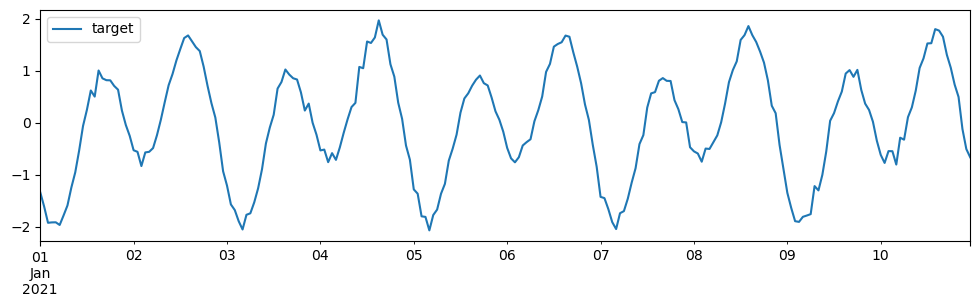

In [3]:
# Load dataframe and plot it
url = (
    "https://gist.githubusercontent.com/rsnirwan/a8b424085c9f44ef2598da74ce43e7a3"
    "/raw/b6fdef21fe1f654787fa0493846c546b7f9c4df2/ts_long.csv"
)
df = pd.read_csv(url, index_col=0, parse_dates=True)
df = df[df["item_id"] == "A"].drop(columns=["item_id"])
print(f"total length: {df.shape[0]}")
print(f"time frequency: {df.index.freq}")
df.plot(figsize=(12, 3))

In [26]:
df.columns

Index(['target'], dtype='object')

In [4]:
# create a sample for the hourly data, using one week data as context window and predicting the next two days.
inp = {
    "target": df["target"].to_numpy()[:168],  # 168 = 24 * 7
    "start": df.index[0].to_period(freq="H"),
}
label = {
    "target": df["target"].to_numpy()[168:216],  # 48 = 24 * 2
    "start": df.index[168].to_period(freq="H"),
}

In [10]:
module = MoiraiModule.from_pretrained(f"Salesforce/moirai-1.1-R-small")

In [24]:
# Prepare model
model = MoiraiForecast(
    module=module,
    prediction_length=48,
    context_length=168,
    patch_size=32,
    num_samples=100,
    target_dim=1,
    feat_dynamic_real_dim=0,
    past_feat_dynamic_real_dim=0,
)

In [ ]:
# Time series values. Shape: (batch, time, variate)
past_target = einops.rearrange(
    torch.as_tensor(inp["target"], dtype=torch.float32), "t -> 1 t 1"
)
# 1s if the value is observed, 0s otherwise. Shape: (batch, time, variate)
past_observed_target = torch.ones_like(past_target, dtype=torch.bool)
# 1s if the value is padding, 0s otherwise. Shape: (batch, time)
past_is_pad = torch.zeros_like(past_target, dtype=torch.bool).squeeze(-1)

In [31]:
168/8

21.0

In [27]:
print(past_target.shape)
print(past_observed_target.shape)
print(past_is_pad.shape)

torch.Size([1, 168, 1])
torch.Size([1, 168, 1])
torch.Size([1, 168])


In [12]:
forecast = model(
    past_target=past_target,
    past_observed_target=past_observed_target,
    past_is_pad=past_is_pad,
)

_convert | patch_size ~ 32
_convert | past_target ~ torch.Size([1, 168, 1])
_convert | past_observed_target ~ torch.Size([1, 168, 1])
_convert | past_is_pad ~ torch.Size([1, 168])
_convert --> |  target~torch.Size([1, 8, 128])
_convert --> |  observed_mask~ torch.Size([1, 8, 128])
_convert --> |  sample_id~torch.Size([1, 8])
_convert --> |  time_id~torch.Size([1, 8])
_convert --> |  variate_id~torch.Size([1, 8])
_convert --> |  prediction_mask~torch.Size([1, 8])
_convert | Target ~ torch.Size([1, 8, 128])
_convert | observed_mask ~ torch.Size([1, 8, 128])
_convert |prediction_mask ~ torch.Size([1, 8])
_convert |sample_id ~ torch.Size([1, 8])
_convert |time_id ~ torch.Size([1, 8])
_convert |variate_id ~ torch.Size([1, 8])
